This notebook aims to identify the CpG sites most significantly associated with age to use as input variables in the ML models and optimal reaction coordinate framework.

First, I need to parse the IDAT files containing the raw DNA methylation data such that it can be preprocessed and normalised. To do this, I will use the Python-based Illumina methylation array analysis software, Mepylome.

In [1]:
#import packages
from pathlib import Path
from mepylome import MethylData
import pandas as pd
import csv
import numpy as np

In [2]:
# Path to analysis directory
analysis_dir = Path("../../7309")

# Read SDRF file into dataframe
df = pd.read_csv(analysis_dir / "Characteristics.csv")

# sort df according to patient and  age
df['ID']=df['Individual'].str.extract(r'IND_(\d+)').astype(int)
df.sort_values(by=['ID', 'Age'],inplace=True)

df.head(10)

,Array_data_file,Sample,Individual,Age,Sex,Twin_pair,ID
1008,9741950045_R03C02,Sample_305,IND_1,89.901370,female,TP_1,1
217,9721365024_R06C02,Sample_635,IND_2,94.000000,female,TP_2,2
635,9721365100_R01C01,Sample_531,IND_3,97.879450,female,TP_3,3
946,9741950003_R05C01,Sample_257,IND_4,66.530134,female,TP_4,4
182,9721365017_R06C01,Sample_778,IND_4,73.568486,female,TP_4,4
417,9721365055_R03C02,Sample_357,IND_4,82.403833,female,TP_4,4
311,9721365040_R02C01,Sample_796,IND_4,84.528405,female,TP_4,4
1036,9741950062_R06C02,Sample_330,IND_5,66.530134,female,TP_4,5
205,9721365023_R06C02,Sample_794,IND_5,73.852509,female,TP_4,5
644,9721365100_R05C02,Sample_541,IND_5,82.403833,female,TP_4,5


In [3]:
df.shape

(1072, 7)

In the SDRF file, each row corresponds to a relationship between a sample and a data file. Here, there are 1072 samples from 385 Swedish twins. The SDRF file contains the following information about the samples:
- Array_data_file is the name of the file
- Sample number 
- Individual number 
- Age shows the age of the individual at the time the sample was taken
- Sex 
- Twin pair
- ID, the number extracted from the individual number

I created a Pandas DataFrame of the SFRF file and sorted the according to patient ID and age. 

In [4]:
import pandas as pd

def read_single_id(df, specific_id):
    combined_data = []

    # Filter the DataFrame for the specific ID
    df_filtered = df[df['ID'] == specific_id]

    # Iterate over each row in the filtered DataFrame
    for _, row in df_filtered.iterrows():
        file_path = analysis_dir / row['Array_data_file']
        data = MethylData(file=file_path).betas.T
        data['ID'] = row['ID']
        data['Age'] = row['Age']
        combined_data.append(data)

    # Concatenate all data into a single DataFrame
    combined_df = pd.concat(combined_data, ignore_index=True)
    combined_df = combined_df[['ID', 'Age'] + [col for col in combined_df.columns if col not in ['ID', 'Age']]]

    return combined_df


In [5]:
new=read_single_id(df,4)

In [6]:
new

,ID,Age,cg13869341,cg14008030,cg12045430,cg20826792,cg00381604,cg20253340,cg21870274,cg03130891,...,cg26983430,cg22051787,cg01757887,cg00061679,cg03930849,cg17939569,cg13365400,cg21106100,cg08265308,cg14273923
0,4,66.530134,0.870562,0.543461,0.043442,0.088099,0.045518,0.599930,0.863954,0.042742,...,0.331210,0.233782,0.425516,0.353853,0.176052,0.466057,0.239427,0.287625,0.579070,0.196425
1,4,73.568486,0.853251,0.529328,0.026819,0.064981,0.040962,0.657034,0.881097,0.009800,...,0.052023,NaN,0.404870,0.597719,0.173280,NaN,NaN,0.332285,0.607527,0.428708
2,4,82.403833,0.886358,0.540541,0.022606,0.077192,0.044258,0.578358,0.807242,0.027501,...,0.213699,0.260958,0.549043,0.748065,0.344610,0.300860,0.519489,0.000000,0.625954,0.254452
3,4,84.528405,0.857370,0.536725,0.053668,0.101207,0.029892,0.614696,0.779669,0.021746,...,0.237736,0.310012,0.552688,0.830550,0.294667,0.082451,0.380741,0.366508,0.660000,NaN


The read_single_id function reads in the IDAT files for one individual, derives the beta values for each CpG site and then creates a pandas dataframe that combines the beta values and corresponding ID and age for that individual.

In [7]:
def read_multiple_ids(df, id_list):
    total_combined_data = []

    for specific_id in id_list:
        combined_df = read_single_id(df, specific_id)
        total_combined_data.append(combined_df)

    total_combined_df = pd.concat(total_combined_data, ignore_index=True)
    return total_combined_df

new=read_multiple_ids(df,[4,5])
new.head(10)

,ID,Age,cg13869341,cg14008030,cg12045430,cg20826792,cg00381604,cg20253340,cg21870274,cg03130891,...,cg26983430,cg22051787,cg01757887,cg00061679,cg03930849,cg17939569,cg13365400,cg21106100,cg08265308,cg14273923
0,4,66.530134,0.870562,0.543461,0.043442,0.088099,0.045518,0.599930,0.863954,0.042742,...,0.331210,0.233782,0.425516,0.353853,0.176052,0.466057,0.239427,0.287625,0.579070,0.196425
1,4,73.568486,0.853251,0.529328,0.026819,0.064981,0.040962,0.657034,0.881097,0.009800,...,0.052023,NaN,0.404870,0.597719,0.173280,NaN,NaN,0.332285,0.607527,0.428708
2,4,82.403833,0.886358,0.540541,0.022606,0.077192,0.044258,0.578358,0.807242,0.027501,...,0.213699,0.260958,0.549043,0.748065,0.344610,0.300860,0.519489,0.000000,0.625954,0.254452
3,4,84.528405,0.857370,0.536725,0.053668,0.101207,0.029892,0.614696,0.779669,0.021746,...,0.237736,0.310012,0.552688,0.830550,0.294667,0.082451,0.380741,0.366508,0.660000,NaN
4,5,66.530134,0.848717,0.519092,0.049242,0.154916,0.037392,0.490773,0.734797,0.083637,...,0.417339,0.744322,0.444469,0.524155,0.208023,0.000000,0.278467,0.355666,0.622642,0.046645
5,5,73.852509,0.794722,0.520067,0.034897,0.066924,0.013951,0.512925,0.871861,0.000000,...,0.488263,NaN,1.000000,0.341783,0.000000,0.000000,0.258869,0.920493,0.520000,0.114270
6,5,82.403833,0.839439,0.524377,0.030680,0.082961,0.026477,0.523755,0.767919,0.148849,...,0.323684,0.260066,0.816490,0.462246,0.158451,0.000000,1.000000,0.363525,0.567961,0.193063
7,5,84.531143,0.825565,0.483741,0.037529,0.052592,0.028231,0.501345,0.808398,1.000000,...,0.234568,0.009219,0.491607,0.311504,0.097927,0.078637,0.228119,0.308422,0.452096,0.100949


The read_multiple_ids function uses the read_single_id function to combine dataframes containing the beta values for different specified individuals. 

In [8]:
#create list of unique ids
import numpy as np

IDs=np.unique(df['ID'])

new=read_multiple_ids(df,IDs[:300]) # take first 300 ids
print(new.shape)
new.head(10)

(622, 485514)


,ID,Age,cg13869341,cg14008030,cg12045430,cg20826792,cg00381604,cg20253340,cg21870274,cg03130891,...,cg26983430,cg22051787,cg01757887,cg00061679,cg03930849,cg17939569,cg13365400,cg21106100,cg08265308,cg14273923
0,1,89.901370,0.804990,0.559082,0.055108,0.145453,0.022129,0.578335,0.827881,0.000000,...,0.155963,0.216440,1.000000,1.000000,0.219219,0.417823,0.506239,0.421166,0.444444,0.353048
1,2,94.000000,0.921955,0.543617,0.039659,0.036193,0.038431,0.819807,0.866538,0.034851,...,0.209040,NaN,0.512759,0.695791,0.294362,NaN,0.168423,0.178421,0.262537,0.204792
2,3,97.879450,0.828315,0.543095,0.049411,0.097823,0.027099,0.676741,0.800854,0.000000,...,0.059259,1.000000,0.605978,0.216119,0.137943,NaN,0.363738,0.347683,0.694444,0.161817
3,4,66.530134,0.870562,0.543461,0.043442,0.088099,0.045518,0.599930,0.863954,0.042742,...,0.331210,0.233782,0.425516,0.353853,0.176052,0.466057,0.239427,0.287625,0.579070,0.196425
4,4,73.568486,0.853251,0.529328,0.026819,0.064981,0.040962,0.657034,0.881097,0.009800,...,0.052023,NaN,0.404870,0.597719,0.173280,NaN,NaN,0.332285,0.607527,0.428708
5,4,82.403833,0.886358,0.540541,0.022606,0.077192,0.044258,0.578358,0.807242,0.027501,...,0.213699,0.260958,0.549043,0.748065,0.344610,0.300860,0.519489,0.000000,0.625954,0.254452
6,4,84.528405,0.857370,0.536725,0.053668,0.101207,0.029892,0.614696,0.779669,0.021746,...,0.237736,0.310012,0.552688,0.830550,0.294667,0.082451,0.380741,0.366508,0.660000,NaN
7,5,66.530134,0.848717,0.519092,0.049242,0.154916,0.037392,0.490773,0.734797,0.083637,...,0.417339,0.744322,0.444469,0.524155,0.208023,0.000000,0.278467,0.355666,0.622642,0.046645
8,5,73.852509,0.794722,0.520067,0.034897,0.066924,0.013951,0.512925,0.871861,0.000000,...,0.488263,NaN,1.000000,0.341783,0.000000,0.000000,0.258869,0.920493,0.520000,0.114270
9,5,82.403833,0.839439,0.524377,0.030680,0.082961,0.026477,0.523755,0.767919,0.148849,...,0.323684,0.260066,0.816490,0.462246,0.158451,0.000000,1.000000,0.363525,0.567961,0.193063


Initially, I will work with a smaller sample of the first 300 individuals, which corresponds to 622 samples. 

In [9]:
# filling NaN  with mean
new.fillna(new.mean(), inplace=True)

# remove column cg01550828
new.drop(columns=['cg01550828'], inplace=True)

new.head(10)

,ID,Age,cg13869341,cg14008030,cg12045430,cg20826792,cg00381604,cg20253340,cg21870274,cg03130891,...,cg26983430,cg22051787,cg01757887,cg00061679,cg03930849,cg17939569,cg13365400,cg21106100,cg08265308,cg14273923
0,1,89.901370,0.804990,0.559082,0.055108,0.145453,0.022129,0.578335,0.827881,0.000000,...,0.155963,0.216440,1.000000,1.000000,0.219219,0.417823,0.506239,0.421166,0.444444,0.353048
1,2,94.000000,0.921955,0.543617,0.039659,0.036193,0.038431,0.819807,0.866538,0.034851,...,0.209040,0.492036,0.512759,0.695791,0.294362,0.591253,0.168423,0.178421,0.262537,0.204792
2,3,97.879450,0.828315,0.543095,0.049411,0.097823,0.027099,0.676741,0.800854,0.000000,...,0.059259,1.000000,0.605978,0.216119,0.137943,0.591253,0.363738,0.347683,0.694444,0.161817
3,4,66.530134,0.870562,0.543461,0.043442,0.088099,0.045518,0.599930,0.863954,0.042742,...,0.331210,0.233782,0.425516,0.353853,0.176052,0.466057,0.239427,0.287625,0.579070,0.196425
4,4,73.568486,0.853251,0.529328,0.026819,0.064981,0.040962,0.657034,0.881097,0.009800,...,0.052023,0.492036,0.404870,0.597719,0.173280,0.591253,0.553391,0.332285,0.607527,0.428708
5,4,82.403833,0.886358,0.540541,0.022606,0.077192,0.044258,0.578358,0.807242,0.027501,...,0.213699,0.260958,0.549043,0.748065,0.344610,0.300860,0.519489,0.000000,0.625954,0.254452
6,4,84.528405,0.857370,0.536725,0.053668,0.101207,0.029892,0.614696,0.779669,0.021746,...,0.237736,0.310012,0.552688,0.830550,0.294667,0.082451,0.380741,0.366508,0.660000,0.415717
7,5,66.530134,0.848717,0.519092,0.049242,0.154916,0.037392,0.490773,0.734797,0.083637,...,0.417339,0.744322,0.444469,0.524155,0.208023,0.000000,0.278467,0.355666,0.622642,0.046645
8,5,73.852509,0.794722,0.520067,0.034897,0.066924,0.013951,0.512925,0.871861,0.000000,...,0.488263,0.492036,1.000000,0.341783,0.000000,0.000000,0.258869,0.920493,0.520000,0.114270
9,5,82.403833,0.839439,0.524377,0.030680,0.082961,0.026477,0.523755,0.767919,0.148849,...,0.323684,0.260066,0.816490,0.462246,0.158451,0.000000,1.000000,0.363525,0.567961,0.193063


I filled in NaNs with the mean and removed the column for site cg01550828 because it only contained NaNs.

Next, linear regression on all variables one-by-one and find those that are most differentially expressed i.e. with the smallest p-values

In [10]:
from scipy.stats import linregress

X_sites, age = new.drop(columns=['ID', 'Age']), new['Age']

results = []

for site in X_sites.columns:
    y = X_sites[site]
    slope, intercept, r_value, p_value, stderr = linregress(age, y)
    results.append((site, slope, p_value, r_value**2))

linregress_sites = pd.DataFrame(results, columns=['Site', 'Slope', 'P_Value', 'R_squared'])

In [11]:
from statsmodels.stats.multitest import multipletests

linregress_sites['Adj_P_Value'] = multipletests(linregress_sites['P_Value'], method='bonferroni')[1]
linregress_sites.head(10)

,Site,Slope,P_Value,R_squared,Adj_P_Value
0,cg13869341,0.000090,0.779542,0.000126,1.0
1,cg14008030,-0.000354,0.173336,0.002988,1.0
2,cg12045430,0.000060,0.476671,0.000817,1.0
3,cg20826792,-0.000438,0.009992,0.010655,1.0
4,cg00381604,-0.000115,0.062200,0.005598,1.0
5,cg20253340,0.000823,0.178837,0.002913,1.0
6,cg21870274,-0.000212,0.626422,0.000382,1.0
7,cg03130891,-0.000485,0.481619,0.000799,1.0
8,cg24335620,0.000233,0.326964,0.001550,1.0
9,cg16162899,-0.000313,0.594091,0.000458,1.0


Since the linear regression is implemented thousands of times, I needed to correct for multiple testing. I used the Bonferroni correction. Linregress_sites now contains the gradient, p-value, $r^2$ and adjusted p-value for each CpG site and is sorted such that the sites with the smallest p-value appear at the top. 

In [12]:
significant_corrected = linregress_sites[linregress_sites['Adj_P_Value'] < 0.05] # 1.02984278e-7
significant_corrected = significant_corrected.sort_values(by='Adj_P_Value')
significant_corrected.shape

(257, 5)

There were 257 sites that were significantly associated with age at an adjusted P-value of 0.05. The volcano plot below shows the 257 CpG sites significantly associated with age and whether they increased or decreased with age.

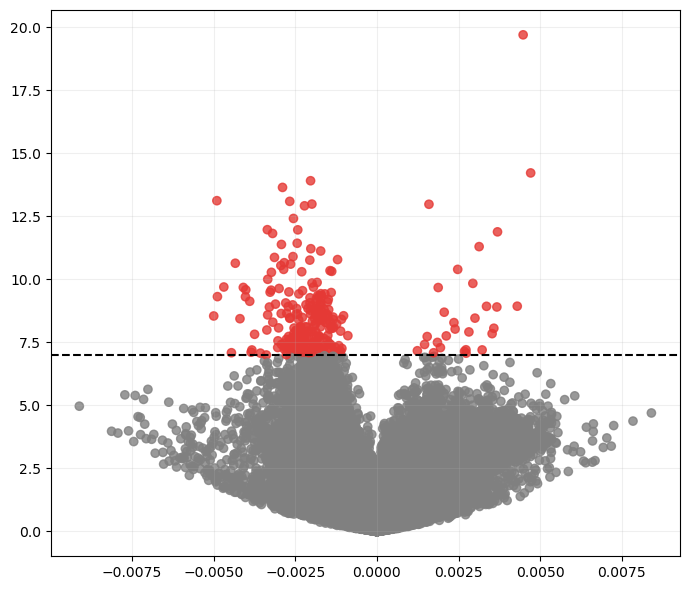

In [12]:
import matplotlib.pyplot as plt

cutoff = 0.05 / 485511

# Calculate -log10(p-value)
linregress_sites['neg_log10_pvalue'] = -np.log10(linregress_sites['P_Value'])

# Define colors: purple for adjusted p >= 0.05, grey for adjusted p < 0.05
colors = ['grey' if p >= cutoff else '#E53935' for p in linregress_sites['P_Value']]

# Create a volcano plot
plt.figure(figsize=(7, 6))
plt.scatter(linregress_sites['Slope'], linregress_sites['neg_log10_pvalue'], 
            c=colors, alpha=0.8)
plt.axhline(-np.log10(cutoff), color='black', linestyle='--')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig("volcano_plot (methylation).png", dpi=1200)
#plt.show() 


However, 257 features are too many, so I will choose the top 50 sites with the smallest p-value as variables for inclusion. 

In [14]:
significant_corrected = linregress_sites.sort_values(by='Adj_P_Value')
significant_corrected = significant_corrected.iloc[:50,:]
significant_corrected.head(50)

,Site,Slope,P_Value,R_squared,Adj_P_Value
154139,cg16867657,0.004478,2.027188e-20,0.129284,9.842221e-15
62659,cg22454769,0.004709,6.071039e-15,0.093595,2.947556e-09
387165,cg07082267,-0.002031,1.238598e-14,0.091540,6.013528e-09
379330,cg10917602,-0.002889,2.276370e-14,0.089782,1.105203e-08
278961,cg23744638,-0.004899,7.651571e-14,0.086272,3.714922e-08
202584,cg26153045,-0.002668,8.128690e-14,0.086097,3.946568e-08
61121,cg02085953,-0.001990,1.041690e-13,0.085377,5.057521e-08
216025,cg07927379,0.001594,1.060244e-13,0.085326,5.147603e-08
89942,cg12554573,-0.002216,1.222276e-13,0.084913,5.934285e-08
223031,cg19216211,-0.002555,3.877785e-13,0.081556,1.882707e-07


In [15]:
significant_sites=significant_corrected[['Site','Adj_P_Value']]
significant_sites.to_csv("significant_sites.csv", index=False)

In [16]:
significant_sites.shape

(50, 2)

I filtered the new dataframe (containing beta values for each CpG site) to only contain the top 50 CpG sites significantly associated with age 